In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
from torch.utils.data import WeightedRandomSampler
from torchvision.models import ResNet50_Weights
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from PIL import Image
from pathlib import Path
import random
import os
from tqdm import tqdm
import math
import time
import numpy as np
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [2]:

class PneumoniaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):

        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.transform = transform
        self.mask_transform = mask_transform
        
        self.image_paths = []
        self.mask_paths = []
        self.labels = []
        
        classes = ["NORMAL", "PNEUMONIA"]
        for idx, cls in enumerate(classes):
            img_files = sorted((self.images_dir / cls).glob("*.png"))
            mask_files = sorted((self.masks_dir / cls).glob("*.png"))
            assert len(img_files) == len(mask_files), f"Mismatch in {cls} images and masks!"
            
            self.image_paths.extend(img_files)
            self.mask_paths.extend(mask_files)
            self.labels.extend([idx] * len(img_files))  # 0: NORMAL, 1: PNEUMONIA
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
    
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale mask
    
        resize = transforms.Resize((img_size, img_size))
        image = resize(image)
        mask = resize(mask)
    
        image_np = np.array(image).astype(np.float32) / 255.0  # (H, W, 3)
        mask_np = np.array(mask).astype(np.float32) / 255.0    # (H, W)

        if mask_np.ndim == 2:
            mask_np = np.expand_dims(mask_np, axis=2)  # (H, W, 1)

        image_masked = image_np * mask_np  

        image_masked = transforms.ToTensor()(image_masked)  # (3, H, W)
        image_masked = transforms.Normalize(mean=[0.485,0.456,0.406],
                                            std=[0.229,0.224,0.225])(image_masked)
    
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image_masked, label


img_size = 512
workers_count = os.cpu_count()
batch_size = 64

image_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

images_dir = "./chest_xray_resized/images"
masks_dir = "./chest_xray_resized/masks"

dataset = PneumoniaDataset(images_dir, masks_dir, transform=image_transform, mask_transform=mask_transform)

train_size = int(0.8 * len(dataset))
val_size = int(len(dataset) * 0.1)
test_size = len(dataset) - val_size - train_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_labels = [train_dataset[i][1].item() for i in range(len(train_dataset))]
label_counts = np.bincount(train_labels)
class_weights = 1.0 / label_counts
samples_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=workers_count)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers_count)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers_count)

print(f"✅ Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

batch = next(iter(train_loader))
print(type(batch))
print(len(batch))
print(batch[0].shape, batch[1].shape)
print(batch[1])


✅ Train size: 4684, Val size: 585, Test size: 587
<class 'list'>
2
torch.Size([64, 3, 512, 512]) torch.Size([64])
tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0])


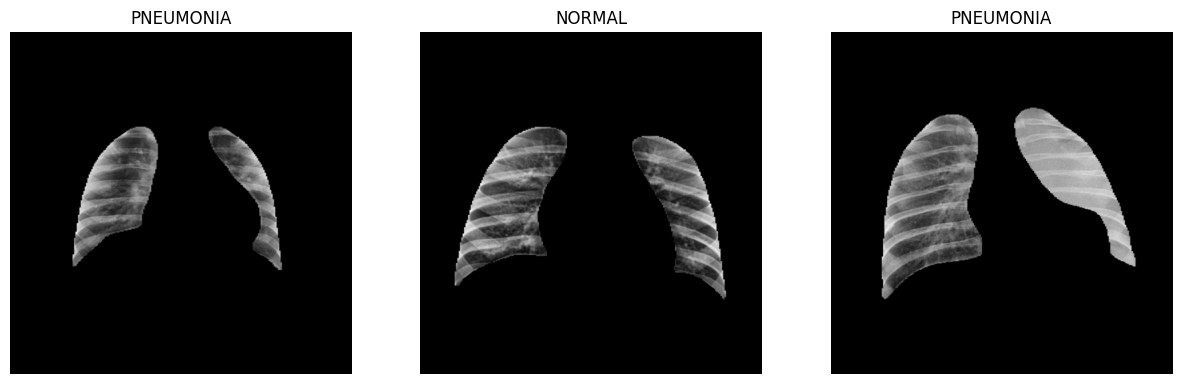

In [3]:
num_samples = 3

images, labels = next(iter(train_loader))

indices = random.sample(range(images.size(0)), num_samples)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    img = images[idx].permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # de-normalize
    img = np.clip(img, 0, 1)

    label = labels[idx].item()
    class_name = "NORMAL" if label == 0 else "PNEUMONIA"

    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.show()

In [4]:
# Flag
distributed_GPU = False  

def get_model():   
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

def setup_model():
    if distributed_GPU:
        # ⚡ DistributedDataParallel
        dist.init_process_group("nccl") 
        local_rank = torch.distributed.get_rank()
        torch.cuda.set_device(local_rank)
        device = torch.device(f"cuda:{local_rank}")
        model = get_model().to(device)
        model = DDP(model, device_ids=[local_rank], output_device=local_rank)
    else:
        # ⚡ DataParallel 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = get_model().to(device)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    return model

model = setup_model()
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s] 


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
checkpoint_dir = Path("./checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_checkpoint.pth"

def get_base_model(m):
    # return underlying module for loading/saving & grouping layers
    if isinstance(m, (nn.DataParallel, DDP)):
        return m.module
    return m

def save_checkpoint(path, state):
    torch.save(state, path)
    print(f"✅ Saved checkpoint: {path}")

def load_checkpoint(path, model, optimizers=None, schedulers=None, device='cuda'):
    ckpt = torch.load(path, map_location=device)
    state_dict = ckpt['model_state_dict']
    # try to load model state dict handling possible "module." prefixes
    model_base = get_base_model(model)
    try:
        model_base.load_state_dict(state_dict)
    except RuntimeError:
        # try removing 'module.' if present in keys
        new_state = {}
        for k, v in state_dict.items():
            if k.startswith("module."):
                new_state[k[7:]] = v
            else:
                new_state[k] = v
        model_base.load_state_dict(new_state)
    # load optimizers & schedulers if provided
    if optimizers is not None and 'optim_state_dicts' in ckpt:
        for i, opt in enumerate(optimizers):
            if i < len(ckpt['optim_state_dicts']):
                opt.load_state_dict(ckpt['optim_state_dicts'][i])
    if schedulers is not None and 'sched_state_dicts' in ckpt:
        for i, sch in enumerate(schedulers):
            if i < len(ckpt['sched_state_dicts']):
                sch.load_state_dict(ckpt['sched_state_dicts'][i])
    print(f"✅ Loaded checkpoint from {path}")
    return ckpt

# ---------- metric helpers (binary) ----------
def compute_metrics_from_counters(tp, fp, fn, tn):
    eps = 1e-8
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return precision, recall, f1, acc

base_model = get_base_model(model)
groups = [
    list(base_model.fc.parameters()),     # group 0: fc
    list(base_model.layer4.parameters()), # group 1
    list(base_model.layer3.parameters()), # group 2
    list(base_model.layer2.parameters()), # group 3
    list(base_model.layer1.parameters()), # group 4
]

# ---------- freeze all then unfreeze first group ----------
for p in base_model.parameters():
    p.requires_grad = False
for p in groups[0]:
    p.requires_grad = True

hyperparams = {
    "batch_size": batch_size,               
    "initial_lr": 1e-4,
    "epochs": 50,
    "patience_unfreeze": 7,
    "patience_early_stop": 15,
    "optimizer": "AdamW",
    "scheduler": "CosineAnnealingLR"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# lr decay per group: group0 (fc) highest lr, earlier layers lower
# lr_groups = [1e-3, 5e-4, 2e-4, 1e-4, 5e-5] # for batch number =16
# lr_groups = [4e-3, 2e-3, 8e-4, 4e-4, 2e-4] #for batch number 64
# lr_groups = [8e-3, 4e-3, 1.6e-3, 8e-4, 4e-4] #for batch number 128
# lr_groups = [1.6e-2, 8e-3, 3.2e-3, 1.6e-3, 8e-4] #for batch number 256
# More conservative learning rates for earlier layers
# lr_groups = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]  # More aggressive decay for earlier layers

# Or even more conservative:
lr_groups = [1e-3, 2e-4, 5e-5, 1e-5, 5e-6]


optimizers = []
schedulers = []
for i in range(len(groups)):
    # optimizer only for parameters in the group (they may be frozen now)
    opt = optim.AdamW(groups[i], lr=lr_groups[i], weight_decay=1e-4)
    sched = CosineAnnealingLR(opt, T_max=hyperparams["epochs"])  # Fixed: optim -> opt
    optimizers.append(opt)
    schedulers.append(sched)

# ---------- state vars for progressive unfreezing ----------
best_val_f1 = -1.0
best_val_acc = -1.0
best_epoch = -1
best_state = None

patience_unfreeze_counter = 0
patience_earlystop_counter = 0
current_group = 0  # index of highest-unfrozen group (0 = only fc)
num_groups = len(groups)

start_epoch = 0

# ---------- optional: resume if checkpoint exists ----------
if checkpoint_path.exists():
    print("Found existing checkpoint. Loading...")
    ckpt = load_checkpoint(str(checkpoint_path), model, optimizers, schedulers, device=str(device))
    # restore bookkeeping if saved
    start_epoch = ckpt.get("epoch", 0) + 1
    current_group = ckpt.get("current_group", current_group)
    patience_unfreeze_counter = ckpt.get("patience_unfreeze_counter", 0)
    patience_earlystop_counter = ckpt.get("patience_earlystop_counter", 0)
    best_val_f1 = ckpt.get("best_val_f1", best_val_f1)
    best_val_acc = ckpt.get("best_val_acc", best_val_acc)
    # ensure param.requires_grad matches current_group
    for gi in range(num_groups):
        flag = (gi <= current_group)
        for p in groups[gi]:
            p.requires_grad = flag
    print(f"Resumed: start_epoch={start_epoch}, current_group={current_group}")

# ---------- training loop (outside function as requested) ----------
num_normal = 1583
num_pneumonia = 4273

total_samples = num_normal + num_pneumonia

class_weights = torch.tensor([
    total_samples / (2 * num_normal),      
    total_samples / (2 * num_pneumonia)    
], dtype=torch.float).to(device)

# CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Reseting tqdm
tqdm._instances.clear()

for epoch in range(start_epoch, hyperparams["epochs"]):
    epoch_start = time.time()
    model.train()
    train_loss = 0.0
    # counters for train metrics (optional)
    t_tp = t_fp = t_fn = t_tn = 0

    # progress bar for train
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{hyperparams['epochs']} - train", ncols=120)

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # zero grads for all active optimizers (groups <= current_group)
        for i in range(current_group + 1):
            optimizers[i].zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)


        # step all active optimizers
        for i in range(current_group + 1):
            optimizers[i].step()

        train_loss += loss.item()

        # update simple counters for train metrics
        preds = outputs.argmax(dim=1)
        t_tp += int(((preds == 1) & (labels == 1)).sum().item())
        t_fp += int(((preds == 1) & (labels == 0)).sum().item())
        t_fn += int(((preds == 0) & (labels == 1)).sum().item())
        t_tn += int(((preds == 0) & (labels == 0)).sum().item())

        pbar.update(1)
    pbar.close()

    # step schedulers only for active groups
    for i in range(current_group + 1):
        schedulers[i].step()

    # compute train metrics (optional logging)
    _, _, train_f1, train_acc = compute_metrics_from_counters(t_tp, t_fp, t_fn, t_tn)

    # ---------- validation ----------
    model.eval()
    v_tp = v_fp = v_fn = v_tn = 0
    val_loss = 0.0

    pbar_val = tqdm(total=len(val_loader), desc=f"Epoch {epoch+1}/{hyperparams['epochs']} - val", ncols=120)
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            v_tp += int(((preds == 1) & (labels == 1)).sum().item())
            v_fp += int(((preds == 1) & (labels == 0)).sum().item())
            v_fn += int(((preds == 0) & (labels == 1)).sum().item())
            v_tn += int(((preds == 0) & (labels == 0)).sum().item())
            pbar_val.update(1)
    pbar_val.close()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / max(1, len(val_loader))
    precision, recall, val_f1, val_acc = compute_metrics_from_counters(v_tp, v_fp, v_fn, v_tn)
    _, _, tr_f1, tr_acc = compute_metrics_from_counters(t_tp, t_fp, t_fn, t_tn)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1} time: {epoch_time:.1f}s | Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")

    # ---------- progressive unfreeze logic ----------
    if val_f1 <= best_val_f1:  # no improvement this epoch
        patience_unfreeze_counter += 1
        patience_earlystop_counter += 1
    else:
        # improvement occurred, reset counters
        patience_unfreeze_counter = 0
        patience_earlystop_counter = 0
        
    # ---------- checkpoint decision (save on better val_f1 OR tie-breaker val_acc) ----------
    save_flag = False
    if val_f1 > best_val_f1 + 5e-4: # 0.05%
        save_flag = True
    elif abs(val_f1 - best_val_f1) < 5e-4 and val_acc > best_val_acc + 5e-4:
        save_flag = True

    if save_flag:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_epoch = epoch
        # save checkpoint with all relevant state
        model_to_save = get_base_model(model)  # underlying module
        ckpt = {
            "epoch": epoch,
            "model_state_dict": model_to_save.state_dict(),
            "optim_state_dicts": [opt.state_dict() for opt in optimizers],
            "sched_state_dicts": [sch.state_dict() for sch in schedulers],
            "best_val_f1": best_val_f1,
            "best_val_acc": best_val_acc,
            "current_group": current_group,
            "patience_unfreeze_counter": patience_unfreeze_counter,
            "patience_earlystop_counter": patience_earlystop_counter,
            "hyperparams": hyperparams
        }
        save_checkpoint(str(checkpoint_path), ckpt)
        print(f'Checkpoint Saved at f1 = {best_val_f1}, val acc = {best_val_acc}.')
        

    # if patience_unfreeze reached -> unfreeze next group (if any)
    if patience_unfreeze_counter >= hyperparams["patience_unfreeze"]:
        if current_group + 1 < num_groups:
            current_group += 1
            print(f"🔓 Unfreezing group {current_group} (now groups 0..{current_group} are trainable)")
            # set requires_grad True for new group
            for p in groups[current_group]:
                p.requires_grad = True
            # reset patience for unfreeze so new group gets time to converge
            patience_unfreeze_counter = 0
            # reset earlystop counter to give new group time (as requested)
            patience_earlystop_counter = 0
        else:
            print("✅ All groups already unfrozen.")
            patience_unfreeze_counter = 0

    # early stopping if patience_earlystop reached
    if patience_earlystop_counter >= hyperparams["patience_early_stop"]:
        print("⏹ Early stopping triggered (no improvement after unfreezing). Stopping training.")
        break

# ---------- after training ----------
print(f"Training finished. Best val F1: {best_val_f1:.4f} at epoch {best_epoch+1 if best_epoch>=0 else 'N/A'}")
# optionally load best model
if checkpoint_path.exists():
    ckpt = torch.load(str(checkpoint_path), map_location=device)
    model_base = get_base_model(model)
    try:
        model_base.load_state_dict(ckpt['model_state_dict'])
    except RuntimeError:
        # strip module. if needed
        new_state = {}
        for k, v in ckpt['model_state_dict'].items():
            if k.startswith("module."):
                new_state[k[7:]] = v
            else:
                new_state[k] = v
        model_base.load_state_dict(new_state)
    print("✅ Best model loaded from checkpoint.")


Found existing checkpoint. Loading...
✅ Loaded checkpoint from checkpoints/best_checkpoint.pth
Resumed: start_epoch=17, current_group=1


Epoch 18/50 - train:  66%|█████████████████████████████████████████                     | 49/74 [00:42<00:19,  1.31it/s]